# Few tests on the integration efficience

In [18]:
### libraries
import sys

sys.path.append('../')

import Velocity_dispersion
import rings2cosmo
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 67.3, Om0 = 0.315)

In [28]:
pd.set_option('display.max_rows', 80)

In [2]:
numerical = pd.read_csv('results.csv')
numerical.head()

,name,numerical_sigma,integral_result,integral_error,epsabs
0,J2321-0939,240.101777,7446.749998,7.946850e+07,0.149
1,J1106+5228,222.047668,6932.458429,6.784547e+07,0.149
2,J1143-0144,264.867997,10395.782864,9.643616e+07,0.149
3,J0841+3824,230.106668,8225.243472,7.272054e+07,0.149
4,J0044+0113,252.925493,10113.812560,8.628597e+07,0.149


The code solves numerically the equation

$$2\int_0^{\infty}\int_R^{\infty}\omega(R)\frac{\nu(r)\sigma^2_r(r)}{\sqrt{r^2 - R^2}}\left (1 - \beta\frac{R^2}{r^2}\right )rdrRdR$$

which has an analitical result

$$ =  \left [\frac{1}{1 + \gamma}\frac{c^2}{2}\frac{Ds}{Dsl}\theta_E \right ] 
\frac{2}{\sqrt{\pi}\lambda(\alpha)(\xi - 2\beta)}\left (\frac{1}{R_E}\right )^{2 - \alpha}\sqrt{\pi}\left [ \lambda (\xi)
   - \beta \lambda(\xi + 2) \right ](2D_L^2\tilde{\sigma}^2_{atm})^{(3-\xi)/2}\frac{1}{2} \Gamma\left ( \frac{3 - \xi}{2} \right ) $$


In [4]:
def analitical_integral(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha,  delta, beta, gamma):
    # Angular diameter distances:
    DS = cosmo.angular_diameter_distance(z_S).value
    DL = cosmo.angular_diameter_distance(z_L).value
    DLS = cosmo.angular_diameter_distance_z1z2(z_L, z_S).value
    RE = theta_E*DL 
    
    c = (const.c).to(u.km/u.second) #light velocity in Km/s This is bc velocity dispersion is measured in (km/s)^2
    clight = c.value
     # \tilde{\sigma}
    chi = theta_ap/seeing_atm

    tilde_sigma = seeing_atm * \
        np.sqrt(1 + (chi ** 2) / 4 + (chi ** 4) / 40)  # Eq. (20)
    
    xi = alpha + delta - 2    
    
    ## constant 
    term_RE  = (1 / (1 + gamma)) * ((clight ** 2) / 2) * (DS / DLS) * theta_E
    term_dynamic = 2/(((np.sqrt(np.pi)))*(Velocity_dispersion.Lambda_function(alpha))*(xi - (2*beta)))
    cte = term_RE*term_dynamic/(RE**(2 - alpha))
    
    ##integral
    x = (3 - xi)/2

    #beta_term = sp.special.beta((xi - 1)/2,0.5) -  (beta*sp.special.beta((xi + 1)/2,0.5))
    beta_term = np.sqrt(np.pi)*(Velocity_dispersion.Lambda_function(xi) - beta*Velocity_dispersion.Lambda_function(xi + 2))
    seeing_term = 2*(DL**2)*(tilde_sigma**2)
    gamma_term = sp.special.gamma(x)

    return cte*beta_term*(seeing_term**x)*gamma_term/2


In [5]:
#### just to test if the above function is working #####
### variables and unity convesion
data = pd.read_csv('../data/sample80.csv')
#data.head()
z_L = data['zl'][0]
z_S = data['zs'][0]
theta_E = (data['theta_E'].values * u.arcsec).to(u.rad)[0].value
theta_ap = (data['theta_ap'].values * u.arcsec).to(u.rad)[0].value
seeing_atm = (data['sigma_atm'].values * u.arcsec).to(u.rad)[0].value
velDisp = data['sigma_ap'][0]
velDispErr = data['d_sigma_ap'][0]
#parameters not related to data
alpha = 2.0
beta = 0.18
delta = 2.4
gamma = 1.0

analitical_integral(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha,  delta, beta, gamma)

7610.464774939843

In [6]:
#### Now I will create a data frame to compare with the numerical integral

Analitical = []
cols = ("name", "z_S", "z_L", "theta_E", "theta_ap","seeing_atm",  "analitical_result")

alpha = 2.0
beta = 0.18
delta = 2.4
gamma = 1.0
epsabs_values = (1.49e-01, 1.49e-02, 1.49e-03, 1.49e-04, 1.49e-05, 1.49e-06, 1.49e-07, 1.49e-08)
data = pd.read_csv('../data/sample80.csv')

for i in range(len(data)):
    ## data
    name = data['name'][i]
    z_L = data['zl'][i]
    z_S = data['zs'][i]
    theta_E = (data['theta_E'].values * u.arcsec).to(u.rad)[i].value
    theta_ap = (data['theta_ap'].values * u.arcsec).to(u.rad)[i].value
    seeing_atm = (data['sigma_atm'].values * u.arcsec).to(u.rad)[i].value
        
    analitical_result = analitical_integral(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha,  delta, beta, gamma)
        
    temp = (name, z_S, z_L, theta_E, theta_ap, seeing_atm, analitical_result)
    Analitical.append (dict(zip(cols,temp)))
    

Analitical = pd.DataFrame(Analitical)
Analitical.head()  

,name,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result
0,J2321-0939,0.532,0.082,0.000008,0.000007,0.000007,7610.464775
1,J1106+5228,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
2,J1143-0144,0.402,0.106,0.000008,0.000007,0.000007,10594.446458
3,J0841+3824,0.657,0.116,0.000007,0.000007,0.000007,8375.053857
4,J0044+0113,0.196,0.120,0.000004,0.000007,0.000007,10113.699232


In [7]:
Analitical.dtypes

name                  object
z_S                  float64
z_L                  float64
theta_E              float64
theta_ap             float64
seeing_atm           float64
analitical_result    float64
dtype: object

In [21]:
full_df = numerical.set_index('name').join(Analitical.set_index('name'))
full_df.head()

,numerical_sigma,integral_result,integral_error,epsabs,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result
name,,,,,,,,,,
CFRS03.1077,274.120064,20019.947600,1.024224e+08,0.149000,2.941,0.938,0.000006,0.000006,0.000004,20230.948701
CFRS03.1077,274.123991,20020.521204,1.115805e+08,0.014900,2.941,0.938,0.000006,0.000006,0.000004,20230.948701
CFRS03.1077,274.123991,20020.521205,1.115805e+08,0.001490,2.941,0.938,0.000006,0.000006,0.000004,20230.948701
CFRS03.1077,274.123991,20020.521205,1.115805e+08,0.000149,2.941,0.938,0.000006,0.000006,0.000004,20230.948701
CFRS03.1077,274.123991,20020.521205,1.115805e+08,0.000015,2.941,0.938,0.000006,0.000006,0.000004,20230.948701


In [22]:
full_df.loc["J1106+5228"]

,numerical_sigma,integral_result,integral_error,epsabs,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result
name,,,,,,,,,,
J1106+5228,222.047668,6932.458429,6.784547e+07,1.490000e-01,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
J1106+5228,222.053821,6932.842653,7.391190e+07,1.490000e-02,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
J1106+5228,222.053821,6932.842654,7.391190e+07,1.490000e-03,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
J1106+5228,222.053821,6932.842654,7.391190e+07,1.490000e-04,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
J1106+5228,222.055508,6932.947970,2.290214e+08,1.490000e-05,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
J1106+5228,222.044268,6932.246123,2.586500e+08,1.490000e-06,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
J1106+5228,222.044268,6932.246123,2.586500e+08,1.490000e-07,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
J1106+5228,222.044293,6932.247660,4.062570e+08,1.490000e-08,0.407,0.096,0.000006,0.000007,0.000007,7072.221482


In [23]:
full_df ['relative_error'] = abs(full_df['integral_result'] - full_df['analitical_result'])/full_df['analitical_result']*100

In [24]:
full_df.head(50)

,numerical_sigma,integral_result,integral_error,epsabs,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result,relative_error
name,,,,,,,,,,,
CFRS03.1077,274.120064,20019.947600,1.024224e+08,1.490000e-01,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.042962
CFRS03.1077,274.123991,20020.521204,1.115805e+08,1.490000e-02,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.123991,20020.521205,1.115805e+08,1.490000e-03,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.123991,20020.521205,1.115805e+08,1.490000e-04,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.123991,20020.521205,1.115805e+08,1.490000e-05,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.117890,20019.629960,4.064725e+08,1.490000e-06,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.044532
CFRS03.1077,274.117951,20019.638945,5.338327e+08,1.490000e-07,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.044488
CFRS03.1077,274.118730,20019.752719,6.525460e+08,1.490000e-08,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.043925
HST14176+5226,271.042414,18736.258191,1.001826e+08,1.490000e-01,3.399,0.810,0.000007,0.000006,0.000004,18942.643976,1.089530


### Relative error

<function matplotlib.pyplot.show(close=None, block=None)>

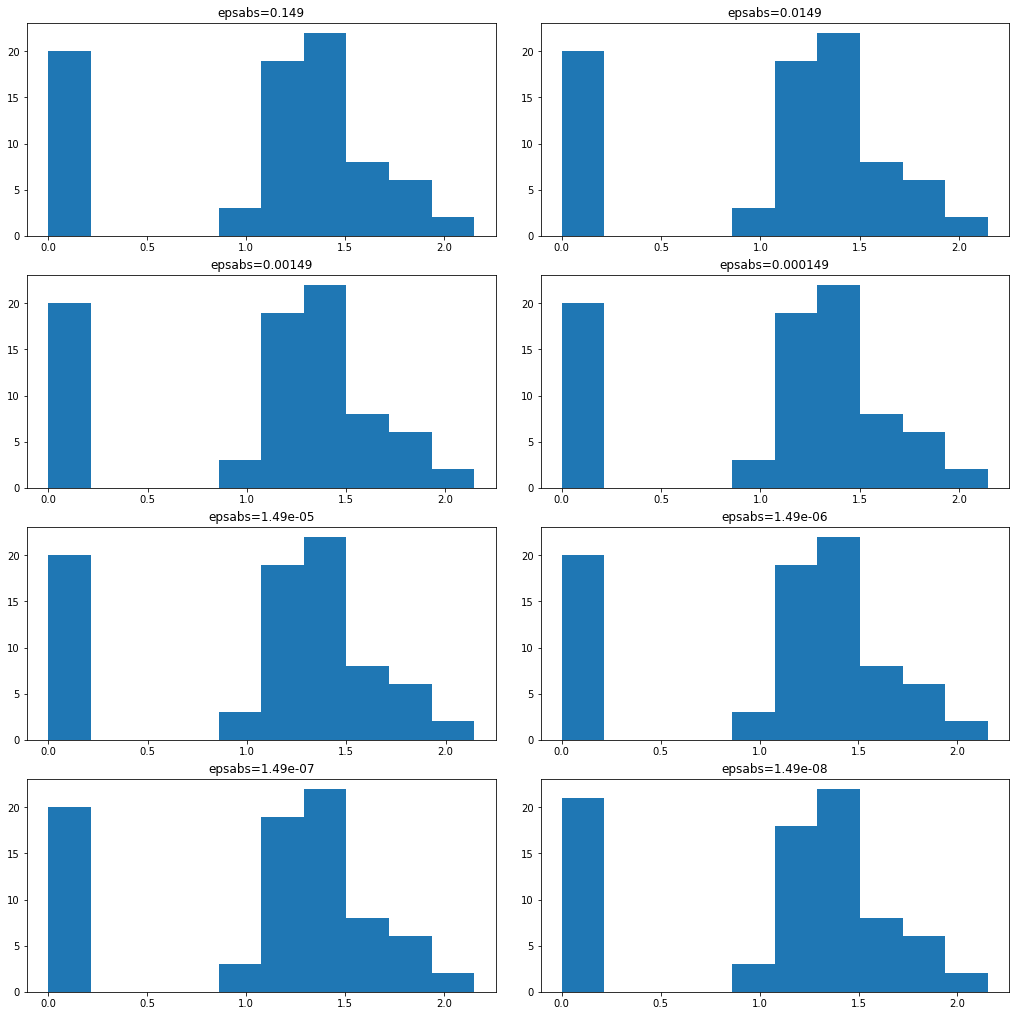

In [59]:
epsabs = full_df['epsabs'].unique()

hor = 2
ver = np.int32(len(epsabs)/2)

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

i = 0

for v in range(ver):
    for h in range (hor):
        filt = (full_df['epsabs'] == epsabs[i])
        ax = fig.add_subplot(gs[v,h])
        ax.hist(full_df.loc[filt, 'relative_error'])
        ax.set_title('epsabs={}'.format(epsabs[i]))
        
        i = i+1

plt.show

In [184]:
filt = (full_df['epsabs'] == 1.490000e-04) & (full_df['relative_error'] < 0.5)
full_df.loc[filt]

,numerical_sigma,integral_result,integral_error,epsabs,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result,relative_error
name,,,,,,,,,,,
J0044+0113,252.925494,10113.812657,9.400126e+07,0.000149,0.196,0.120,0.000004,0.000007,0.000007,10113.699232,0.001121
J0109+1500,228.078363,12565.055240,5.879523e+07,0.000149,0.525,0.294,0.000003,0.000007,0.000007,12565.024320,0.000246
J0151+0049,198.744155,12843.492268,5.804188e+07,0.000149,1.364,0.517,0.000003,0.000005,0.000009,12843.474810,0.000136
J0157-0056,252.111339,18833.822343,7.183879e+07,0.000149,0.924,0.513,0.000004,0.000007,0.000007,18833.791935,0.000161
J0747+4448,203.790702,12779.593509,4.694002e+07,0.000149,0.897,0.437,0.000003,0.000005,0.000009,12779.580076,0.000105
J0830+5116,261.835088,22462.665100,1.007415e+08,0.000149,1.332,0.530,0.000006,0.000005,0.000009,22462.635140,0.000133
J0944-0147,219.242955,15829.513704,7.063242e+07,0.000149,1.179,0.539,0.000003,0.000005,0.000009,15829.492934,0.000131
J1020+1122,284.556569,19219.278978,1.189843e+08,0.000149,0.553,0.282,0.000006,0.000007,0.000007,19219.242240,0.000191
J1215+0047,319.058544,35205.210492,1.150576e+08,0.000149,1.297,0.642,0.000007,0.000005,0.000009,35205.173693,0.000105


In [185]:
filt = (full_df['epsabs'] == 1.490000e-04) & (full_df['relative_error'] > 0.5)
full_df.loc[filt]

,numerical_sigma,integral_result,integral_error,epsabs,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result,relative_error
name,,,,,,,,,,,
CFRS03.1077,274.123991,20020.521205,1.115805e+08,0.000149,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
HST14176+5226,271.046465,18736.818229,1.091404e+08,0.000149,3.399,0.810,0.000007,0.000006,0.000004,18942.643976,1.086573
J0029-0055,202.325725,8834.574223,6.093520e+07,0.000149,0.931,0.227,0.000005,0.000007,0.000007,8949.490609,1.284055
J0037-0942,265.592272,14224.245521,1.050979e+08,0.000149,0.632,0.196,0.000007,0.000007,0.000007,14422.447218,1.374258
J0212-0555,260.512370,15198.110735,1.009759e+08,0.000149,2.740,0.750,0.000006,0.000004,0.000003,15388.539105,1.237469
J0213-0743,340.244622,25159.263219,1.723095e+08,0.000149,3.480,0.717,0.000012,0.000005,0.000003,25484.218059,1.275122
J0214-0405,277.450920,17637.633829,1.145013e+08,0.000149,1.880,0.609,0.000007,0.000005,0.000004,17853.569452,1.209482
J0217-0513,270.255389,18686.686498,1.085005e+08,0.000149,1.847,0.646,0.000006,0.000007,0.000003,18891.305450,1.083138
J0219-0829,233.189183,10276.382618,8.109343e+07,0.000149,2.150,0.389,0.000006,0.000005,0.000003,10429.314765,1.466368


array([[<AxesSubplot:xlabel='z_S', ylabel='z_S'>,
        <AxesSubplot:xlabel='z_L', ylabel='z_S'>,
        <AxesSubplot:xlabel='theta_E', ylabel='z_S'>,
        <AxesSubplot:xlabel='theta_ap', ylabel='z_S'>,
        <AxesSubplot:xlabel='seeing_atm', ylabel='z_S'>,
        <AxesSubplot:xlabel='analitical_result', ylabel='z_S'>,
        <AxesSubplot:xlabel='relative_error', ylabel='z_S'>],
       [<AxesSubplot:xlabel='z_S', ylabel='z_L'>,
        <AxesSubplot:xlabel='z_L', ylabel='z_L'>,
        <AxesSubplot:xlabel='theta_E', ylabel='z_L'>,
        <AxesSubplot:xlabel='theta_ap', ylabel='z_L'>,
        <AxesSubplot:xlabel='seeing_atm', ylabel='z_L'>,
        <AxesSubplot:xlabel='analitical_result', ylabel='z_L'>,
        <AxesSubplot:xlabel='relative_error', ylabel='z_L'>],
       [<AxesSubplot:xlabel='z_S', ylabel='theta_E'>,
        <AxesSubplot:xlabel='z_L', ylabel='theta_E'>,
        <AxesSubplot:xlabel='theta_E', ylabel='theta_E'>,
        <AxesSubplot:xlabel='theta_ap', ylabel='th

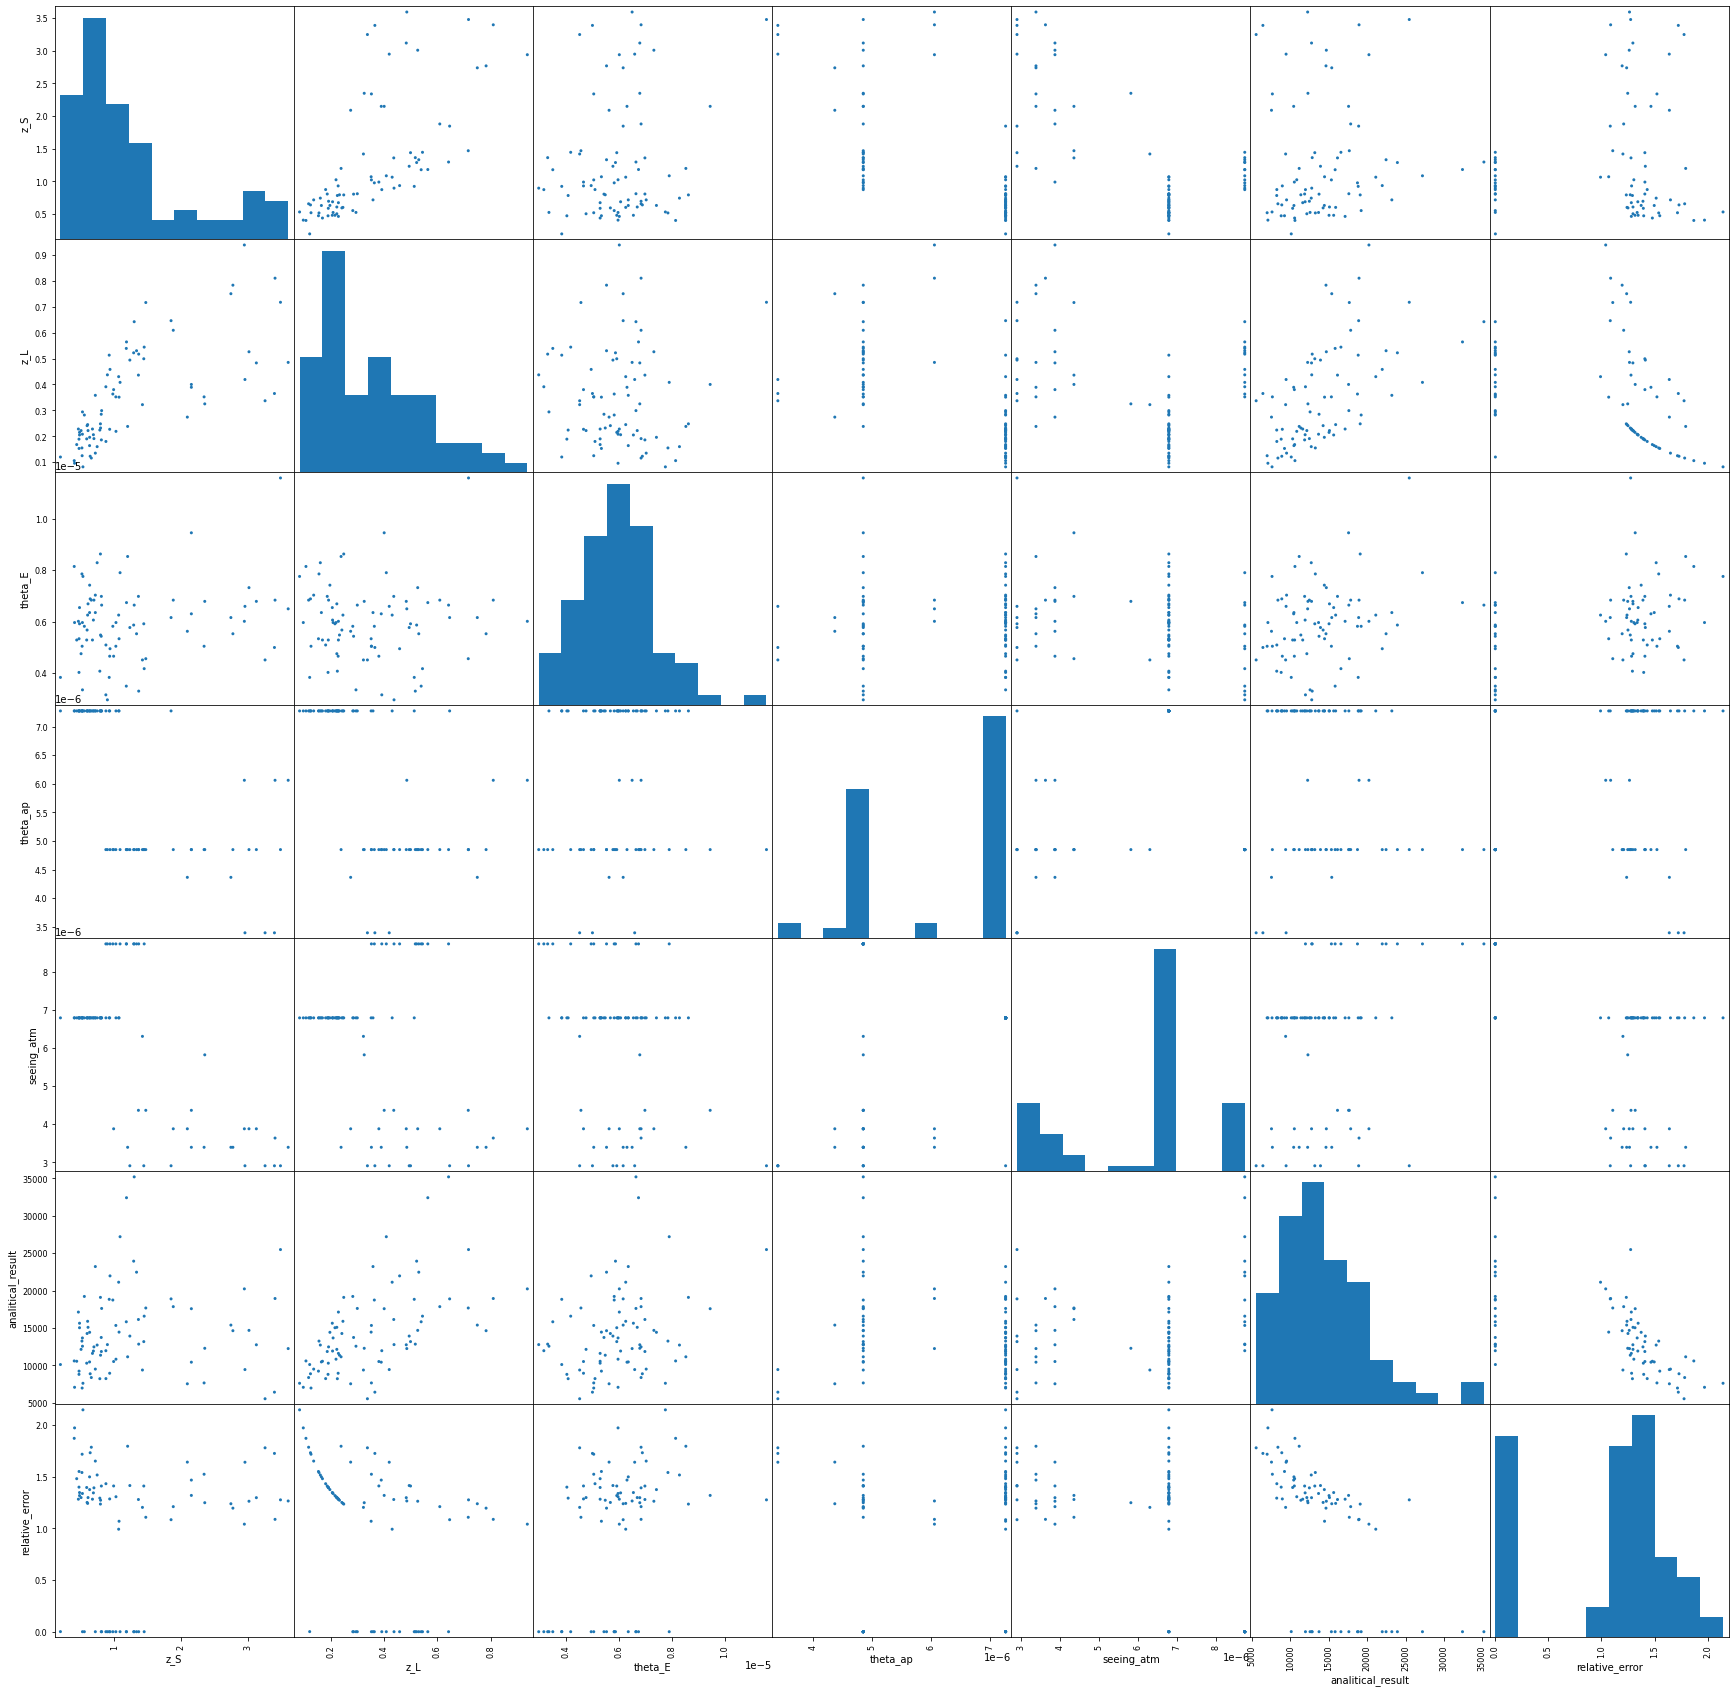

In [205]:
filt = (full_df['epsabs'] == 1.490000e-04)

test = full_df.loc[filt, ['z_S','z_L','theta_E','theta_ap','seeing_atm','analitical_result','relative_error']]
pd.plotting.scatter_matrix(test, figsize=(30,30), alpha=1)

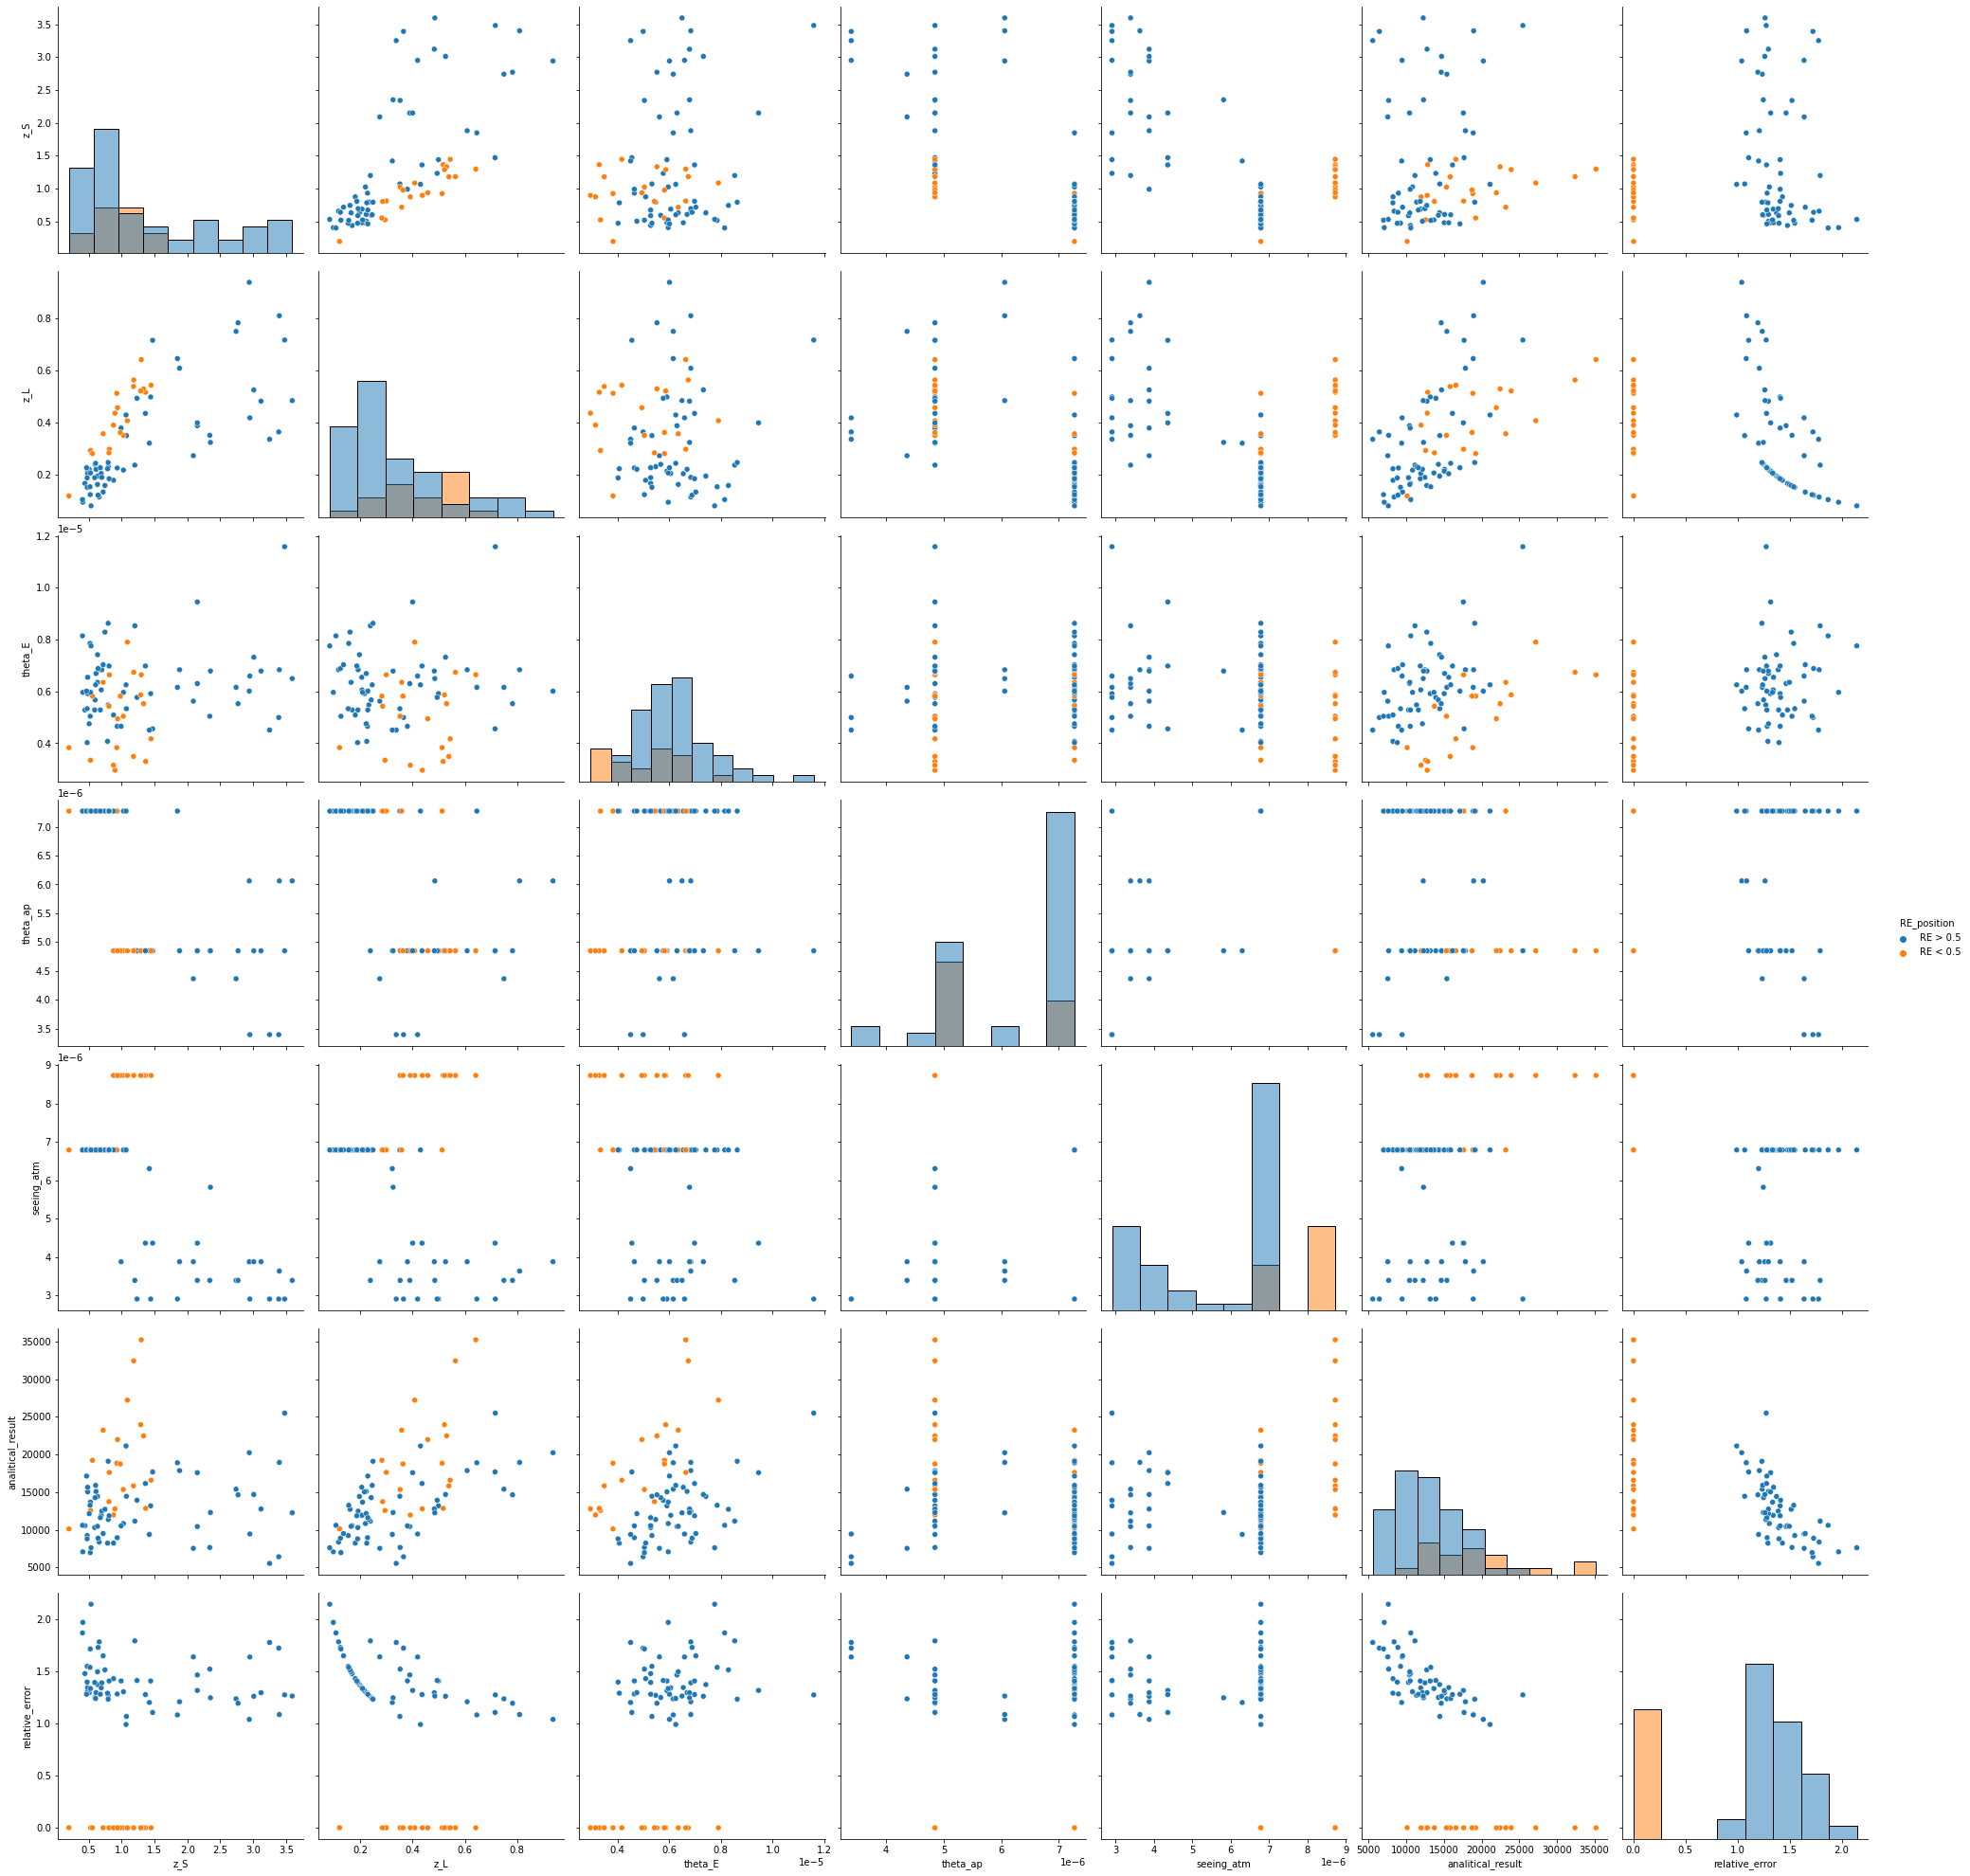

In [223]:
import seaborn as sns


filt = (full_df['epsabs'] == 1.490000e-04)
test = full_df.loc[filt, ['z_S','z_L','theta_E','theta_ap','seeing_atm','analitical_result','relative_error']]

err_color = []
for name in test.index:
    if test.loc[name, 'relative_error'] < 0.5:
        err_color.append('RE < 0.5')
    else:
        err_color.append('RE > 0.5')
                    
                         
test['RE_position'] = err_color
#test

sns.pairplot(test, hue='RE_position', diag_kind='hist', height=4)

In [211]:
names = test.index
names[0]
test.loc[names[0], 'relative_error']

1.040126685531719

### Integration error

<function matplotlib.pyplot.show(close=None, block=None)>

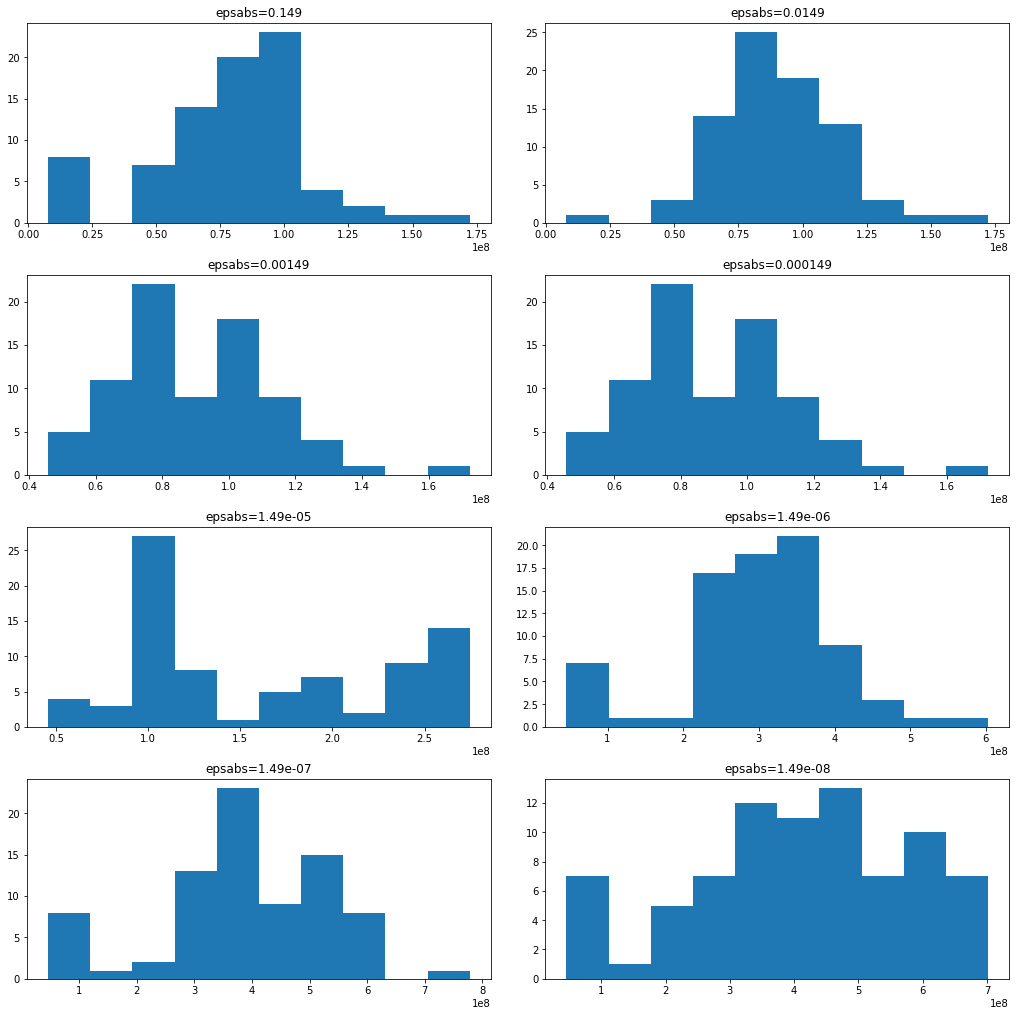

In [67]:
epsabs = full_df['epsabs'].unique()

hor = 2
ver = np.int32(len(epsabs)/2)

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

i = 0

for v in range(ver):
    for h in range (hor):
        filt = (full_df['epsabs'] == epsabs[i])
        ax = fig.add_subplot(gs[v,h])
        ax.hist(full_df.loc[filt, 'integral_error'])
        ax.set_title('epsabs={}'.format(epsabs[i]))
        
        i = i+1

plt.show

integral_error    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

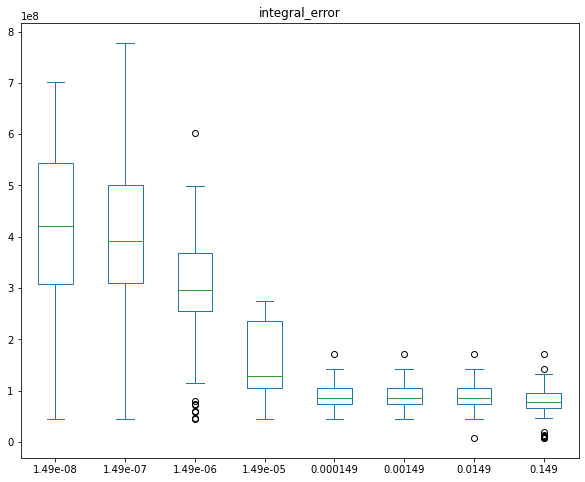

In [121]:
full_df.plot.box(column = 'integral_error', by ='epsabs', figsize=(10, 8))

obs from 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad

epsabsfloat or int, optional

    Absolute error tolerance. Default is 1.49e-8. quad tries to obtain an accuracy of abs(i-result) <= max(epsabs, epsrel*abs(i)) where i = integral of func from a to b, and result is the numerical approximation. See epsrel below.



In [122]:
# J0044+0113

full_df.loc['J0044+0113']

,numerical_sigma,integral_result,integral_error,epsabs,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result,relative_error
name,,,,,,,,,,,
J0044+0113,252.925493,10113.812560,8.628597e+07,1.490000e-01,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001121
J0044+0113,252.925494,10113.812666,9.400126e+07,1.490000e-02,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001122
J0044+0113,252.925494,10113.812656,9.400126e+07,1.490000e-03,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001121
J0044+0113,252.925494,10113.812657,9.400126e+07,1.490000e-04,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001121
J0044+0113,252.925494,10113.812657,9.400126e+07,1.490000e-05,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001121
J0044+0113,252.925494,10113.812657,3.289515e+08,1.490000e-06,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001121
J0044+0113,252.925494,10113.812657,4.497287e+08,1.490000e-07,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001121
J0044+0113,252.925494,10113.812657,5.497390e+08,1.490000e-08,0.196,0.12,0.000004,0.000007,0.000007,10113.699232,0.001121


(0.0011204840009408168, 0.0011216398288591257)

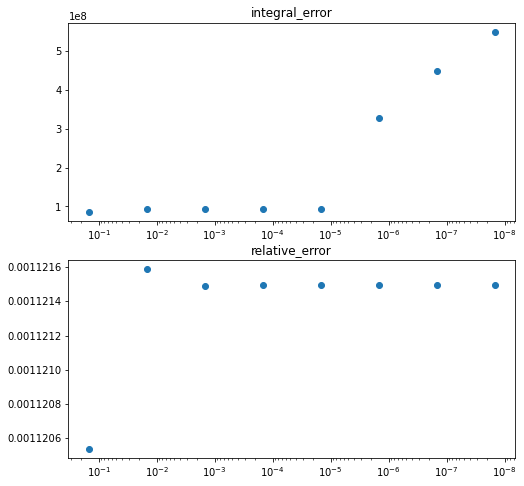

In [168]:
plt.figure(figsize=(8, 8))
ax1 =  plt.subplot(2, 1, 1)
ax1.scatter(full_df.loc['J0044+0113', 'epsabs'], full_df.loc['J0044+0113']['integral_error'])
ax1.set_xscale('log')
ax1.invert_xaxis()
ax1.set_title('integral_error')

ax2 =  plt.subplot(2, 1, 2, sharex=ax1)
ax2.scatter(full_df.loc['J0044+0113', 'epsabs'], full_df.loc['J0044+0113']['relative_error'])
#ax2.set_xscale('log')
#ax2.invert_xaxis()
ax2.set_title('relative_error')
ax2.set_ylim()

Text(0.5, 1.0, 'relative_error')

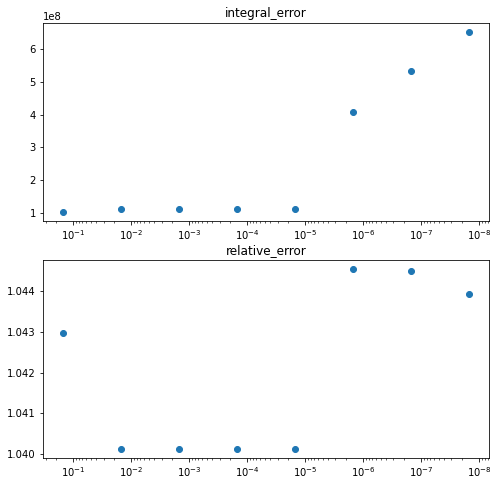

In [182]:
SL_names = full_df.index.unique()
i = 0

plt.figure(figsize=(8, 8))
ax1 =  plt.subplot(2, 1, 1)
ax1.scatter(full_df.loc[SL_names[i], 'epsabs'], full_df.loc[SL_names[i],'integral_error'])
ax1.set_xscale('log')
ax1.invert_xaxis()
ax1.set_title('integral_error')

ax2 =  plt.subplot(2, 1, 2, sharex=ax1)
ax2.scatter(full_df.loc[SL_names[i], 'epsabs'], full_df.loc[SL_names[i],'relative_error'])
#ax2.set_xscale('log')
#ax2.invert_xaxis()
ax2.set_title('relative_error')


In [181]:
full_df.loc[SL_names[0]]

,numerical_sigma,integral_result,integral_error,epsabs,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result,relative_error
name,,,,,,,,,,,
CFRS03.1077,274.120064,20019.947600,1.024224e+08,1.490000e-01,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.042962
CFRS03.1077,274.123991,20020.521204,1.115805e+08,1.490000e-02,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.123991,20020.521205,1.115805e+08,1.490000e-03,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.123991,20020.521205,1.115805e+08,1.490000e-04,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.123991,20020.521205,1.115805e+08,1.490000e-05,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.040127
CFRS03.1077,274.117890,20019.629960,4.064725e+08,1.490000e-06,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.044532
CFRS03.1077,274.117951,20019.638945,5.338327e+08,1.490000e-07,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.044488
CFRS03.1077,274.118730,20019.752719,6.525460e+08,1.490000e-08,2.941,0.938,0.000006,0.000006,0.000004,20230.948701,1.043925
